# Playing with Ray Data

This notebook follows Ray Data's original example: [Image Classification Batch Inference with PyTorch](https://docs.ray.io/en/latest/data/examples/pytorch_resnet_batch_prediction.html).

In the example, an image dataset (Imagenette) is loaded with Ray, do some preprocessing and use a pre-trained ResNet model to make inferences on them.

You can find that code as a Python script that you can submit to Ray as a Job: `ray_demo/batch_classification.py`.

This notebook launches that job and then we play a lil bit with the results:

- We load a batch of images, apply a function to transform the record and then plot the results.

In [1]:
import ray
import os

In [ ]:
from dotenv import load_dotenv

load_dotenv(ROOT_DIR / ".env")

In [3]:
os.environ["AWS_PROFILE"] = "<your AWS profile>" # Update accordingly
os.environ["RAY_ADDRESS"] = "http://<head-node-public-ip>:8265/" # Update accordingly

## Processing data in Ray

We can submit Jobs to a Ray cluster.

The following cell submits the same job as the one explained in the README. In this case, instead of using the CLI we are using the [Python SDK](https://docs.ray.io/en/latest/cluster/running-applications/job-submission/sdk.html)

In [29]:
from ray.job_submission import JobSubmissionClient

from ray_demo.utils.constants import ROOT_DIR

ray_client = JobSubmissionClient()

ray_client.submit_job(
    submission_id="ray-demo-batch-classification",
    entrypoint="python ray_demo/batch_classification.py",
    runtime_env={
        "working_dir": str(ROOT_DIR),
        "pip": ["torch==2.2.2", "torchvision==0.17.2"]
    }
)

2024-07-16 23:20:36,212	INFO dashboard_sdk.py:338 -- Uploading package gcs://_ray_pkg_8f8e2450f48f4ef4.zip.
2024-07-16 23:20:36,216	INFO packaging.py:530 -- Creating a file package for local directory '/Users/facundopalavecino/Documents/DEV/facu/ray-lightning-demo'.


'ray-demo-batch-classification'

Let's wait for the job to complete

In [30]:
async for lines in ray_client.tail_job_logs("ray-demo-batch-classification"):
    print(lines, end="")

2024-07-16 19:20:38,453	INFO job_manager.py:530 -- Runtime env is setting up.
2024-07-16 19:21:57,700	INFO worker.py:1445 -- Using address 10.0.1.170:6379 set in the environment variable RAY_ADDRESS
2024-07-16 19:21:57,700	INFO worker.py:1585 -- Connecting to existing Ray cluster at address: 10.0.1.170:6379...
2024-07-16 19:21:57,705	INFO worker.py:1761 -- Connected to Ray cluster. View the dashboard at 10.0.1.170:8265 
2024-07-16 19:22:03,438	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-16_19-05-39_311376_177/logs/ray-data
2024-07-16 19:22:03,438	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadImage->Map(preprocess_image)] -> ActorPoolMapOperator[MapBatches(ResnetModel)] -> TaskPoolMapOperator[Write]
(autoscaler +25s) Tip: use `ray status` to view detailed cluster status. To disable these messages, set RAY_SCHEDULER_EVENTS=0.
(autoscaler +25s) Adding 2 node(s) o

## Local Cluster

By default, Ray can spawn a cluster in the local machine. It will recognize the available resources.

Let's create one so that we can interact we the results of the job submitted a few moments ago.

In [4]:
ray.init(address="local")

2024-07-18 18:08:10,237	INFO worker.py:1761 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


RayContext(dashboard_url='127.0.0.1:8265', python_version='3.11.9', ray_version='2.30.0', ray_commit='97c37298df9e997b86ca9efed824e27024f3bd60')

Due to resource constrains, I can't load the entire dataset. Let's pick a random batch of predictions.

In [5]:
ds = ray.data.read_json(
    "s3://ray-demo-data/batch_classification/7_000004_000000.json",
    override_num_blocks=8
)

In [6]:
from typing import Any, Dict
import numpy as np

def transform_record(record: Dict[str, Any]) -> Dict[str, Any]:
    """Maps each record in the batch to another directory."""
    return {
        "predicted_label": record['predicted_label'],
        "image": record['original_image']
    }

In [7]:
ds_transformed = ds.map(transform_record).take_all()

2024-07-18 18:09:22,651	INFO streaming_executor.py:108 -- Starting execution of Dataset. Full logs are in /tmp/ray/session_2024-07-18_18-08-06_011980_94213/logs/ray-data
2024-07-18 18:09:22,668	INFO streaming_executor.py:109 -- Execution plan of Dataset: InputDataBuffer[Input] -> TaskPoolMapOperator[ReadJSON] -> TaskPoolMapOperator[Map(transform_record)]


- ReadJSON->SplitBlocks(8) 1:   0%|          | 0/1 [00:00<?, ?it/s]

- Map(transform_record) 2:   0%|          | 0/1 [00:00<?, ?it/s]

Running 0:   0%|          | 0/1 [00:00<?, ?it/s]

In [8]:
len(ds_transformed)

48

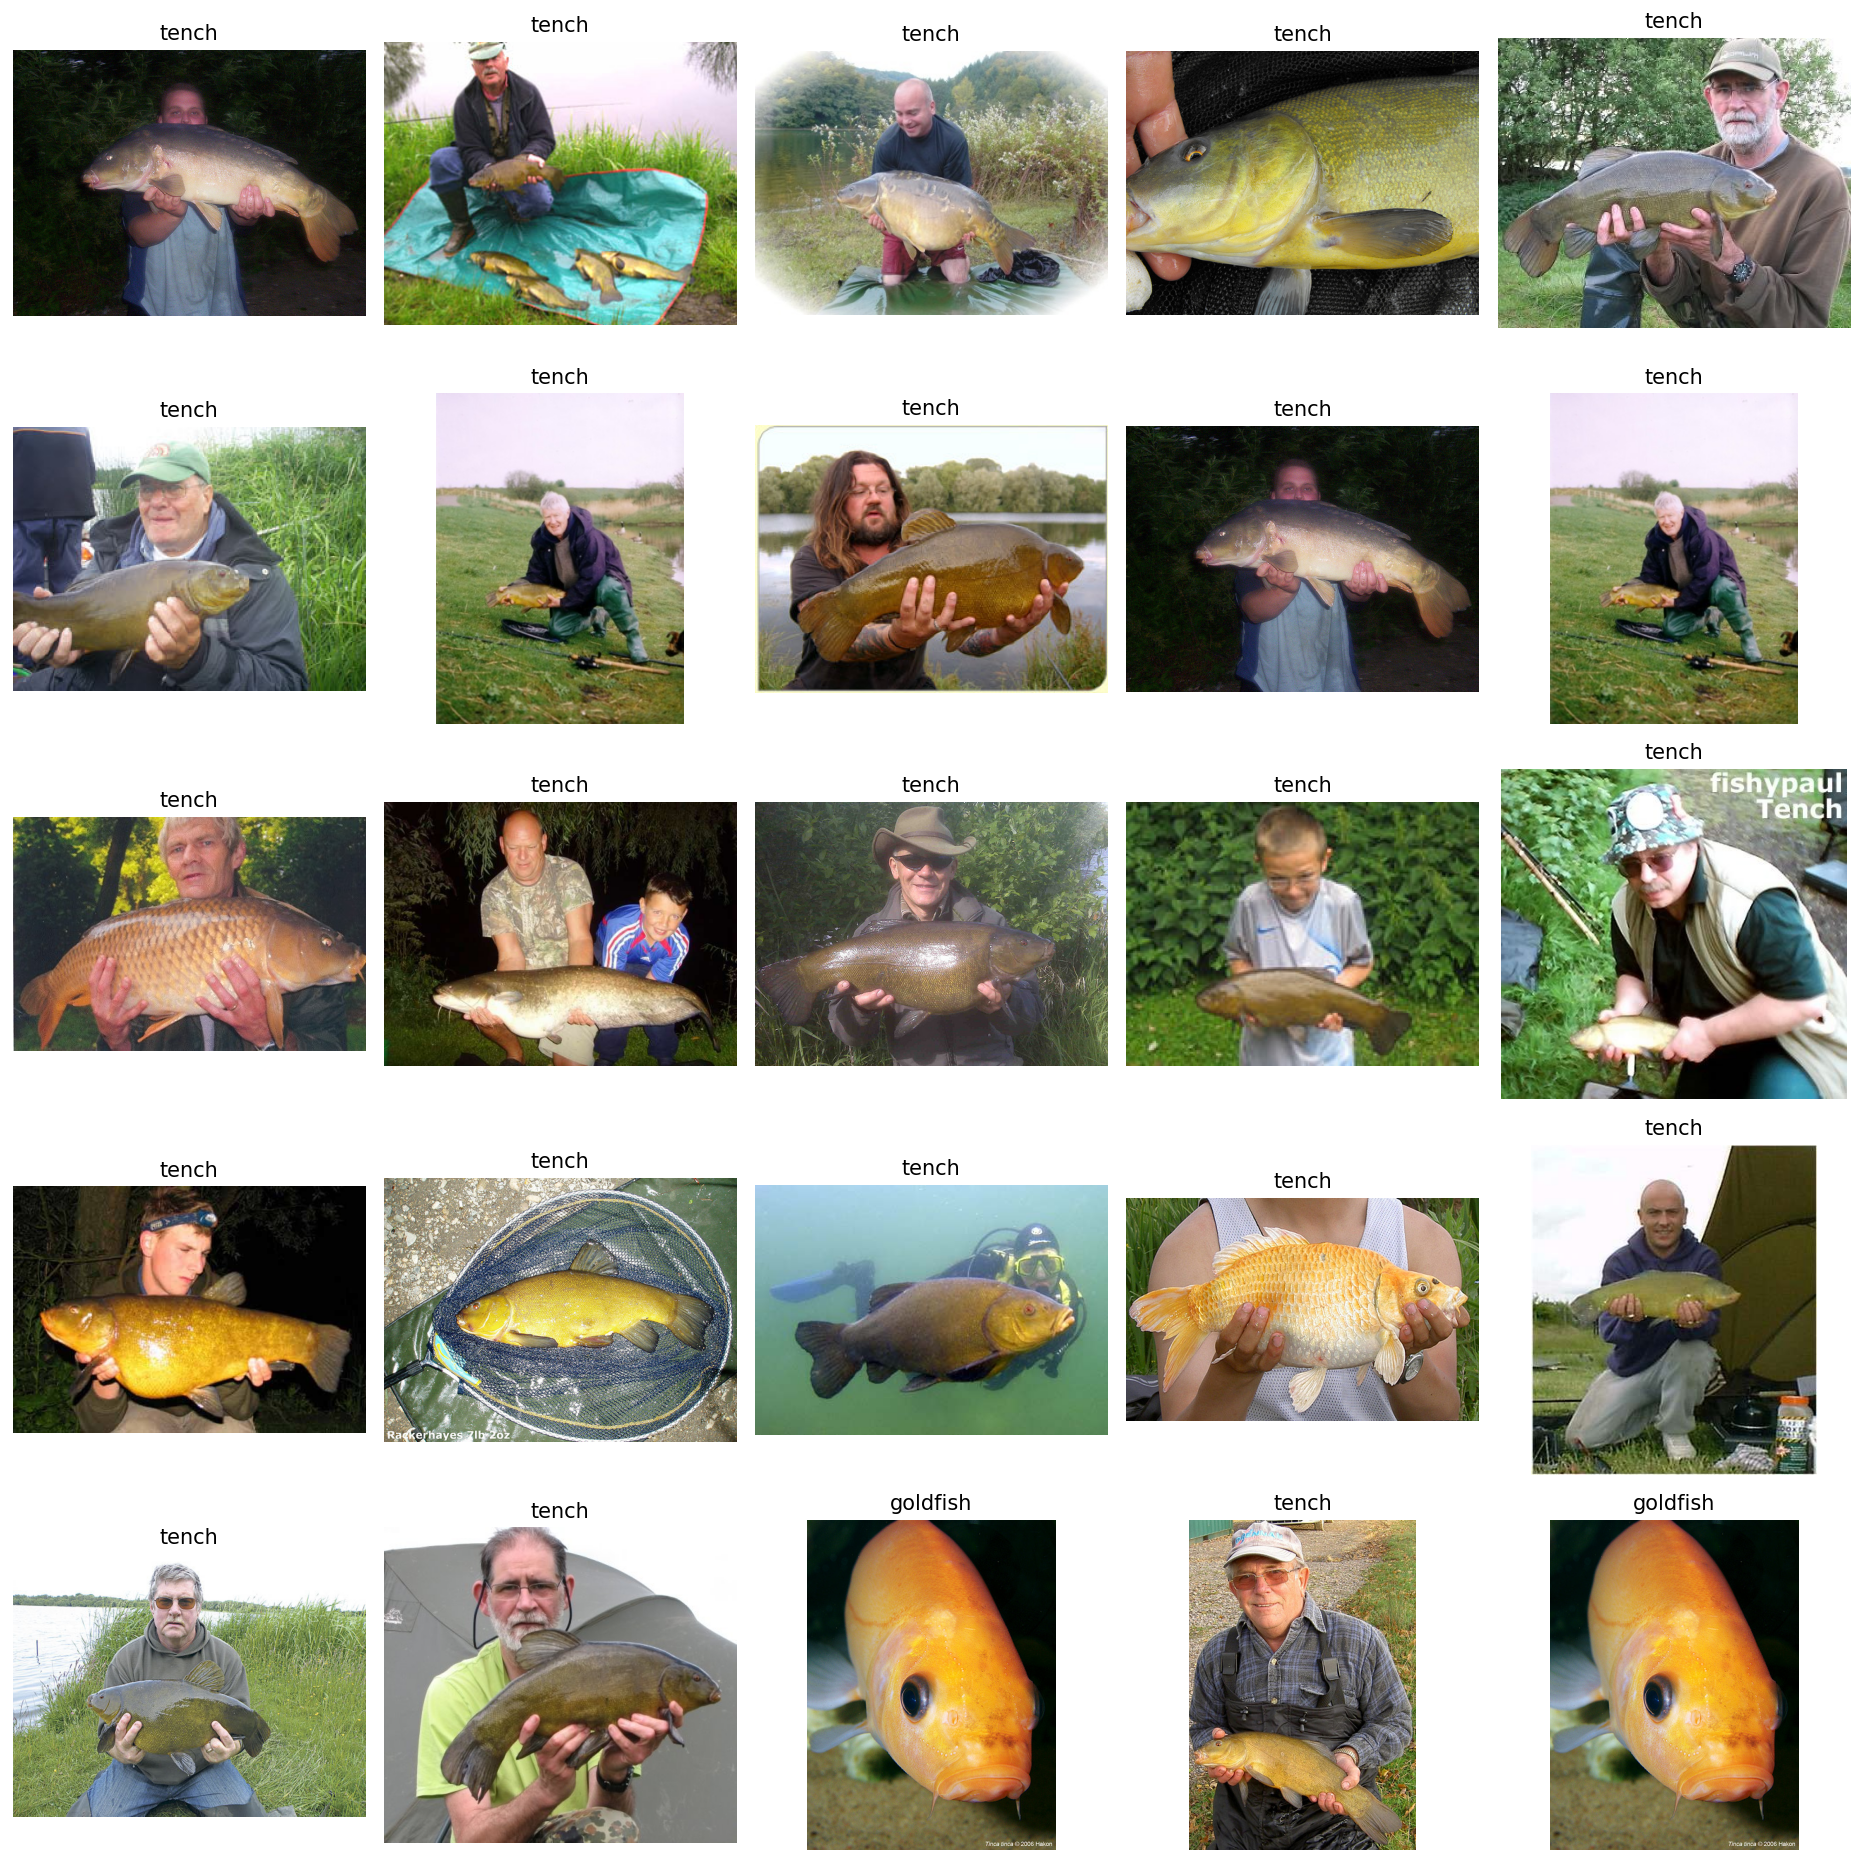

In [10]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(15, 15), dpi=125)

for row in range(5):
    for col in range(5):
        item = ds_transformed[int(np.random.random()*len(ds_transformed))]
        axs[row, col].imshow(item["image"])
        axs[row, col].axis('off')
        axs[row, col].set_title(item["predicted_label"])

plt.tight_layout()